Classifying handwritten digits using Tensorflow (binary classification).
--
In this notebook we will do binary classification of MNIST handwritten digits. More precisely, we will do classification of digit 9 vs the rest. 

You should have in the same directory as this notebook file the Python pickle file mnist_bin_classification_9vsRest.pickle. You can download this file from: 

http://webhome.cs.uvic.ca/~thomo/mnist_bin_classification_9vsRest.pickle

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import time
import pickle
import tensorflow as tf

%matplotlib inline

In [16]:
# Let's load the dataset of handwritten digits from a Python pickle file. 
# For information on pickle files, see: https://pythontips.com/2013/08/02/what-is-pickle-in-python
# The pickle file contains 55,000 training images and their labels as well as
# 10,000 test images and their labels.

fileObject = open("mnist_bin_classification_9vsRest.pickle",'rb')  
X,Y,X_test,Y_test = pickle.load(fileObject)
fileObject.close()

[False]
[False]


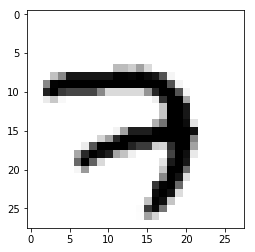

In [17]:
# Let's view some images

plt.figure()
plt.imshow(X[0,:].reshape((28,28)), cmap='Greys')

print(Y[0])
print(Y_test[0])

# Feel free to display other images by changing the index 0 above to some other index. 

In [18]:
# We will reshape the Y arrays so that they are not rank 1 arrays but rank 2 arrays. 
# They should be rank 2 arrays.

Y = Y.reshape((Y.shape[0],1))
Y_test = Y_test.reshape((Y_test.shape[0],1))

print("Train dataset shape", X.shape, Y.shape)
print("Test dataset shape", X_test.shape, Y_test.shape)

print("Y =", Y)

m   = X.shape[0] 
n_x = X.shape[1]

Train dataset shape (55000, 784) (55000, 1)
Test dataset shape (10000, 784) (10000, 1)
Y = [[False]
 [False]
 [False]
 ..., 
 [False]
 [False]
 [False]]


Compute the accuracy
--
Compute the accuracy of binary classification on the train and test datasets.

In [19]:
def accuracy(A, Y):
    P = A>.5      #prediction
    num_agreements = np.sum(P==Y)
    return num_agreements / Y.shape[0]

Implement the logistic regression binary classifier on Tensorflow
--

In [20]:
# Input data.
# Load the training and test data into constants
tf_X = tf.constant(X)
tf_Y = tf.constant(Y.astype(np.float32))
tf_X_test = tf.constant(X_test)
tf_Y_test = tf.constant(Y_test.astype(np.float32))

# Variables.
# These are the parameters that we are going to be training.
tf_w = tf.Variable( tf.zeros((n_x, 1)) )
tf_b = tf.Variable(tf.zeros((1,1)))

# Training computation.
# We multiply the inputs with the weight matrix, and add biases. We compute
# the sigmoid and cross-entropy (it's one operation in TensorFlow, because
# it's very common, and it can be optimized). We take the average of this
# cross-entropy across all training examples: that's our cost.
tf_Z = tf.matmul(tf_X, tf_w) + tf_b
tf_J = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z) )

# Optimizer.
# We are going to find the minimum of this loss using gradient descent.
# We pass alpha=0.1 as input parameter.
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(tf_J)

# Predictions for the train and test data.
# These are not part of training, but merely here so that we can report
# accuracy figures as we train.
tf_A = tf.nn.sigmoid(tf_Z)
tf_A_test = tf.nn.sigmoid(tf.matmul(tf_X_test, tf_w) + tf_b)

In [13]:
session = tf.InteractiveSession()

# This is a one-time operation which ensures the parameters get initialized as
# we described in the graph: random weights for the matrix, zeros for the biases. 
tf.global_variables_initializer().run()
print("Initialized")

for iter in range(10):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the cost value and the training predictions returned as numpy arrays.
    _, J, A = session.run([optimizer, tf_J, tf_A])
    
    print(iter, J)

Initialized
0 0.693259
1 0.362494
2 0.338161
3 0.326896
4 0.31924
5 0.313017
6 0.307529
7 0.302505
8 0.29783
9 0.293443


In [21]:
# Calling .eval() is basically like calling run(), but
# just to get that one numpy array. 
# Note that it recomputes all its computation graph dependencies.
A = tf_A.eval()
A_test = tf_A_test.eval()

print("Accuracy on the train set is ", accuracy(A,Y))
print("Accuracy on the test set is ", accuracy(A_test,Y_test))

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

Stochastic Gradient Descent
--
Here we want to do batch stochastic gradient descent and approximate the gradient using batches of training examples.  

In [17]:
# Input data.
# Let's use placeholders for the training data. 
# This is so that we can suply batches of tranining examples each iteration.
tf_X = tf.placeholder(tf.float32)
tf_Y = tf.placeholder(tf.float32)

tf_X_test = tf.constant(X_test)
tf_Y_test = tf.constant(Y_test.astype(np.float32))

# Variables.
# These are the parameters that we are going to be training.
tf_w = tf.Variable( tf.zeros((n_x, 1)) )
tf_b = tf.Variable(tf.zeros((1,1)))

# Training computation.
# We multiply the inputs with the weight matrix, and add biases. We compute
# the sigmoid and cross-entropy (it's one operation in TensorFlow, because
# it's very common, and it can be optimized). We take the average of this
# cross-entropy across all training examples: that's our cost.
tf_Z = tf.matmul(tf_X, tf_w) + tf_b
tf_J = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_Y, logits=tf_Z) )

# Optimizer.
# We are going to find the minimum of this loss using gradient descent.
# We pass alpha=0.1 as input parameter.
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(tf_J)

# Predictions for the train and test data.
# These are not part of training, but merely here so that we can report
# accuracy figures as we train.
tf_A = tf.nn.sigmoid(tf_Z)
tf_A_test = tf.nn.sigmoid(tf.matmul(tf_X_test, tf_w) + tf_b)

In [19]:
num_steps = 5001
batch_size = 100

tf.global_variables_initializer().run()
print("Initialized")

for step in range(num_steps):
    # Pick an offset within the training data.
    offset = (step * batch_size) % (X.shape[0] - batch_size)
    
    # Generate a minibatch.
    X_batch = X[offset:(offset + batch_size), :]
    Y_batch = Y[offset:(offset + batch_size), :]
    
    _, J, A = session.run([optimizer, tf_J, tf_A], feed_dict={tf_X : X_batch, tf_Y : Y_batch})
    
    if (step % 500 == 0):
        print("Minibatch loss at step ", (step, J))
        print("Minibatch accuracy: ", accuracy(A, Y_batch))
        A_test = tf_A_test.eval()
        print("Test accuracy: ", accuracy(A_test,Y_test))

Initialized
Minibatch loss at step  (0, 0.69314742)
Minibatch accuracy:  0.92
Test accuracy:  0.8991
Minibatch loss at step  (500, 0.11886039)
Minibatch accuracy:  0.96
Test accuracy:  0.9529
Minibatch loss at step  (1000, 0.095326357)
Minibatch accuracy:  0.97
Test accuracy:  0.9588
Minibatch loss at step  (1500, 0.11317737)
Minibatch accuracy:  0.95
Test accuracy:  0.9598
Minibatch loss at step  (2000, 0.049157977)
Minibatch accuracy:  0.99
Test accuracy:  0.9623
Minibatch loss at step  (2500, 0.30240571)
Minibatch accuracy:  0.9
Test accuracy:  0.9632
Minibatch loss at step  (3000, 0.061813116)
Minibatch accuracy:  0.99
Test accuracy:  0.9636
Minibatch loss at step  (3500, 0.16863389)
Minibatch accuracy:  0.92
Test accuracy:  0.9639
Minibatch loss at step  (4000, 0.18505821)
Minibatch accuracy:  0.94
Test accuracy:  0.962
Minibatch loss at step  (4500, 0.16158779)
Minibatch accuracy:  0.92
Test accuracy:  0.9641
Minibatch loss at step  (5000, 0.062602691)
Minibatch accuracy:  0.99
T